## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

import tensorflow as tf
from itertools import chain
from random import sample

from skimage import io
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(6)
# Todo

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
86387,00021298_008.png,Infiltration,8,21298,77,M,PA,2892,2946,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
77413,00019018_015.png,Consolidation|Infiltration,15,19018,29,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
60146,00014840_000.png,No Finding,0,14840,18,M,PA,2670,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8164,00002143_010.png,No Finding,10,2143,31,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45394,00011632_022.png,Infiltration,22,11632,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
31991,00008362_023.png,Infiltration,23,8362,28,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
len(all_xray_df[(all_xray_df['Patient Age'] > 115)])

16

The command above shows that there are patient above 115 years old, which seems to be unrealistic, or that there was an human error at the moment of entering the data

In [6]:
all_xray_df = all_xray_df[(all_xray_df['Patient Age'] < 115)]

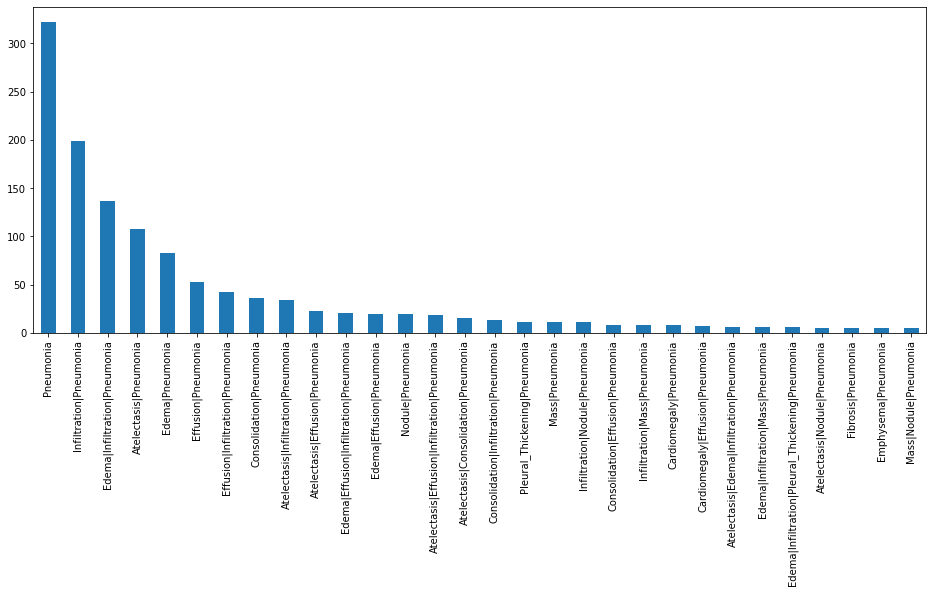

In [7]:
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

## Create your training and testing data:

In [8]:
def create_splits(dataframe1,label1,testsize,ratio_neg2pos):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_data, valid_data = skl.train_test_split(dataframe1, 
                                   test_size = testsize, 
                                   stratify = dataframe1[label1])
    
    p_inds = valid_data[valid_data[label1]==1].index.tolist()
    np_inds = valid_data[valid_data[label1]==0].index.tolist()
    # The following code pulls a random sample of negative-label data that's ratio times as big as the positive label sample.
    np_sample = sample(np_inds,ratio_neg2pos*len(p_inds))
    valid_data = valid_data.loc[p_inds + np_sample]
    print("Number of images for training: %0.2f" % len(train_data))
    print("Number of images for validation: %0.2f" % len(valid_data))
    #print("Ratio of positive labels: %0.2f" % valid_data[label1].sum()/len(valid_data))
    return train_data, valid_data

In [9]:
train_xray_df, val_xray_df = create_splits(all_xray_df,'Pneumonia',0.2,2)

Number of images for training: 89683.00
Number of images for validation: 858.00


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
img1 = all_xray_df['path'][0]

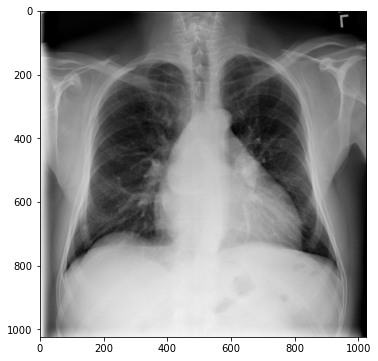

In [11]:
plt.figure(figsize=(6,6))
img = io.imread(img1)
plt.imshow(img,cmap='gray')

In [12]:
def my_image_augmentation(bHorizontalFlip,hShiftRange,wShiftRange,rotRange,shearRange,zoomRange):
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = bHorizontalFlip, 
                              vertical_flip = False, 
                              height_shift_range= hShiftRange, 
                              width_shift_range=wShiftRange, 
                              rotation_range=rotRange, 
                              shear_range = shearRange,
                              zoom_range=zoomRange)
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
    return my_idg


def make_train_gen(df,idg,IMG_SIZE,BATCH_SIZE,targetLabel):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
     # Todo
    train_gen = idg.flow_from_dataframe(dataframe=df,
                                         directory=None,
                                         x_col = 'path',
                                         y_col = targetLabel,
                                         class_mode = 'raw',
                                         target_size = IMG_SIZE,
                                         batch_size = BATCH_SIZE
                                         )
    return train_gen


def make_val_gen(val_data,my_val_idg,IMG_SIZE,BATCH_SIZE,targetLabel):
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data,
                                              directory=None,
                                              x_col = 'path',
                                              y_col = targetLabel,
                                              class_mode = 'raw',
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE
                                             )
    # Todo
    return val_gen

In [13]:
IMG_SIZE = (224,224)

In [14]:
BATCH_SIZE = 31

In [15]:
train_idg = my_image_augmentation(True,0.1,0.1,20,0.1,0.1)

In [16]:
train_gen = make_train_gen(train_xray_df,train_idg,IMG_SIZE,BATCH_SIZE,'Pneumonia')

Found 89683 validated image filenames.


In [17]:
val_idg = ImageDataGenerator(rescale=1. / 255.0)

In [18]:
BATCH_SIZE = 13

In [19]:
val_gen = make_val_gen(val_xray_df,val_idg,IMG_SIZE,BATCH_SIZE,'Pneumonia')

Found 858 validated image filenames.


In [20]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

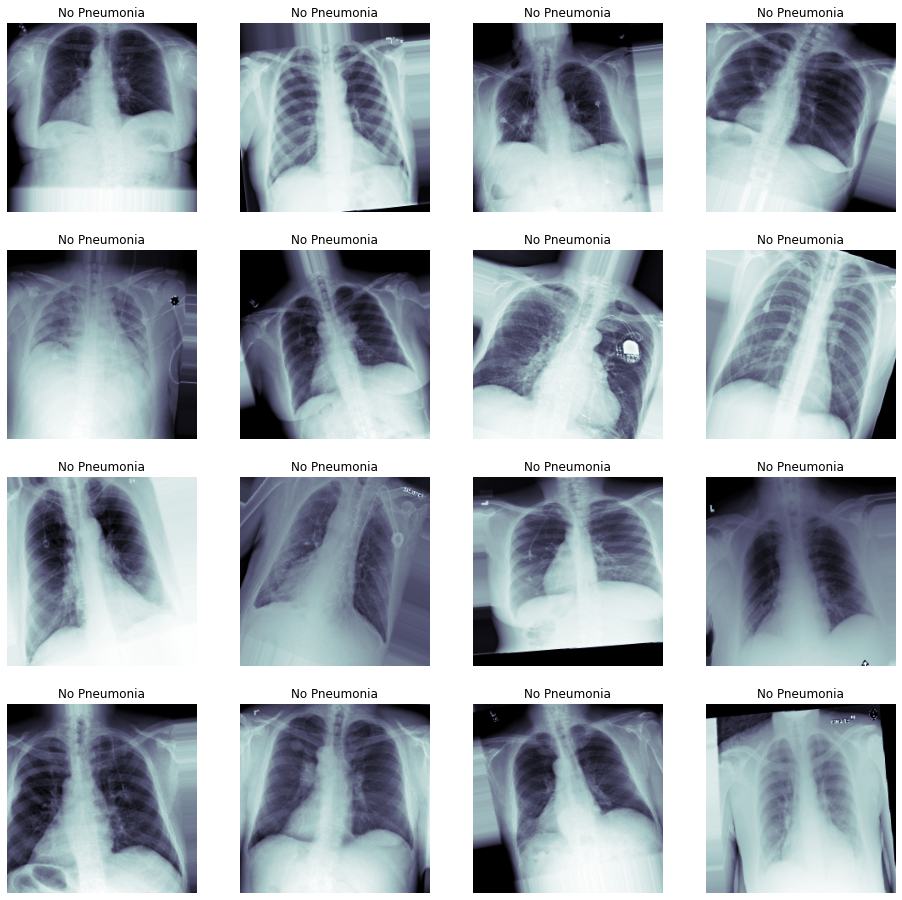

In [21]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [22]:
def load_pretrained_model(lay_of_interest, imgsize):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    model.summary()
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input,outputs=transfer_layer.output)
    return vgg_model


In [23]:
def build_my_model(baseline_model,Nfreeze):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    for layer in baseline_model.layers[0:Nfreeze]:
        layer.trainable = False
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    my_model = Sequential()
    my_model.add(baseline_model)
    
    
    
    my_model.add(Flatten())
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Build optimizer
    optimizer = Adam(lr=1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    # compile model
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [24]:
preModel = load_pretrained_model('block5_pool',IMG_SIZE)

553467904/553467096 [==============================] - 7s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [ ]:
my_model = build_my_model(preModel,18)

In [26]:
for layer in preModel.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [27]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'min', 
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                       mode= 'min',patience=1)

callbacks_list = [checkpoint, early]

### Start training! 

In [31]:
## train your model

# Todo

history = my_model.fit_generator(train_gen,
                           validation_data = (valX, valY),
                           epochs = 1,
                           callbacks = callbacks_list)

Epoch 1/1
   2/2893 [..............................] - ETA: 19:00:41 - loss: 0.1138 - binary_accuracy: 1.0000

KeyboardInterrupt: 

In [29]:
weight_path="{}_my_model.best.hdf5".format('xray_class')

In [30]:
my_model.load_weights(weight_path)

ValueError: Shapes (25088, 1) and (4608, 1) are incompatible

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [19]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

NameError: name 'new_model' is not defined

In [ ]:
def plot_auc(groundTruth, algorithmOutput):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(groundTruth, algorithmOutput)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

In [11]:
## plot figures
#plot_auc(pred_Y,pred_Y)
# Todo
plot_history(history)

NameError: name 'plot_history' is not defined

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)